In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import time
from tqdm.notebook import tqdm
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.15.0


In [93]:
df = pd.read_csv("../data/raw/training_set_rel3.tsv", delimiter="\t", encoding="ISO-8859-1")
df.shape

(12976, 28)

In [99]:
os.path.dirname(os.path.realpath('__file__'))

'/home/betelgeuse/Desktop/projects/automatic-essay-grading/notebooks'

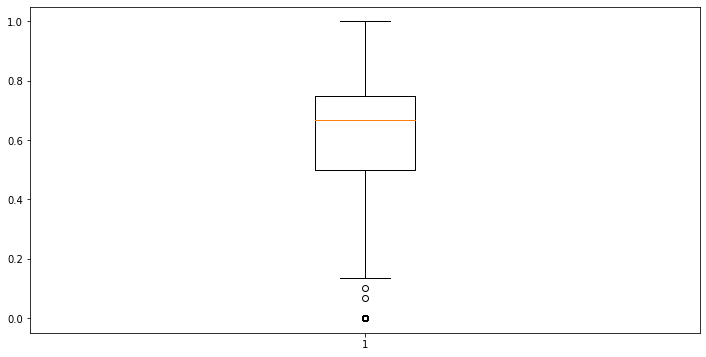

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.boxplot(df.score)

plt.show()

In [94]:
df.loc[:, 'score'] = 0

# For essay_set = 1
ind = df.index[df['essay_set']==1]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/12

# For essay_set = 2
ind = df.index[df['essay_set']==2]
for i in ind:
    df.loc[i,'score'] = ((df['domain1_score'][i]/6) + (df['domain2_score'][i]/4))/2

# For essay_set = 3
ind = df.index[df['essay_set']==3]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/3

# For essay_set = 4
ind = df.index[df['essay_set']==4]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/3

# For essay_set = 5
ind = df.index[df['essay_set']==5]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/4

# For essay_set = 6
ind = df.index[df['essay_set']==6]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/4

# For essay_set = 7
ind = df.index[df['essay_set']==7]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/30

# For essay_set = 8
ind = df.index[df['essay_set']==8]
for i in ind:
    df.loc[i,'score'] = df['domain1_score'][i]/60

df = df[["essay", "score"]]
df.head()

,essay,score
0,"Dear local newspaper, I think effects computer...",0.666667
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.750000
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.583333
3,"Dear Local Newspaper, @CAPS1 I have found that...",0.833333
4,"Dear @LOCATION1, I know having computers has a...",0.666667


## Preparing the Data

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
import numpy as np
import pickle
import os


Using TensorFlow backend.


In [87]:
docs_text = []

for essay in tqdm(df['essay'], total=len(df)):
    essay = clean_text(essay)
    word_sequence = text_to_word_sequence(essay)
    docs_text.extend(word_sequence)

print(len(docs_text), len(set(docs_text)))


1407133 39605


In [69]:
word_counts = {}
for word, count in tokenizer.word_counts.items():
    if count >= 16:
        word_counts[word] = count

len(word_counts), max(word_counts.values()), min(word_counts.values())

(4989, 20932, 16)

In [85]:
tokenizer.texts_to_matrix(["dear book hello", "how are you speaker"]).sum(axis=1)

array([3., 1.])

In [52]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(docs_text)

word_index = tokenizer.word_index

# Increment the index by 1 to take padding token at index 0
word_index = {word: index + 1 for word, index in word_index.items()}

# Add padding and unkown token
# word_index['<PAD>'] = 0
# word_index['<UNK>'] = len(word_index)

index_word = {index: word for word, index in word_index.items()}


In [86]:
len(index_word)

39605

In [35]:
import re
from nltk.corpus import stopwords
from collections import defaultdict
import numpy as np
import pandas as pd

# A list of contractions from https://stackoverflow.com/q/19790188/9865225
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}


def clean_text(text, remove_stopwords=True):
    """Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings"""

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?://.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if w not in stops]
        text = " ".join(text)

    return text


def count_words(text):
    """Count the number of occurrences of each word in a set of text"""
    count_dict = defaultdict(int)
    for sentence in text:
        for word in sentence.split():
            count_dict[word] += 1
    return dict(count_dict)


def convert_to_ints(text, word_count, unk_count, vocab_to_int, eos=False):
    """Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts"""
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count


def load_embeddings(glove_dir):
    embeddings_index = {}
    with open(glove_dir, encoding='utf-8') as f:
        for line in tqdm(f, total=400000):
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding

    print('Word embeddings:', len(embeddings_index))
    return embeddings_index


def convert_vocab_to_int(word_counts, embeddings_index, threshold=20):
    # Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

    # dictionary to convert words to integers
    vocab_to_int = {}

    value = 0
    for word, count in word_counts.items():
        if count >= threshold or word in embeddings_index:
            vocab_to_int[word] = value
            value += 1

    # Special tokens that will be added to our vocab
    codes = ["<UNK>", "<PAD>", "<EOS>", "<GO>"]

    # Add codes to vocab
    for code in codes:
        vocab_to_int[code] = len(vocab_to_int)

    # Dictionary to convert integers to words
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word

    usage_ratio = round(len(vocab_to_int) / len(word_counts), 4) * 100

    print("Total number of unique words:", len(word_counts))
    print("Number of words we will use:", len(vocab_to_int))
    print("Percent of words we will use: {}%".format(usage_ratio))
    
    return vocab_to_int


def unk_counter(sentence, vocab_to_int):
    """Counts the number of time UNK appears in a sentence."""
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count


def clean_reviews(lengths_texts, int_texts, vocab_to_int):
    # Sort the summaries and texts by the length of the texts, shortest to longest
    # Limit the length of summaries and texts based on the min and max ranges.
    # Remove reviews that include too many UNKs

    # sorted_summaries = []
    sorted_texts = []
    max_text_length = 150
    # max_summary_length = 13
    min_length = 2
    unk_text_limit = 10
    # unk_summary_limit = 0

    for _ in tqdm(range(min(lengths_texts.counts), max_text_length)):
        for count in range(len(int_texts)):
            if (unk_counter(int_texts[count], vocab_to_int) <= unk_text_limit and len(
                    int_texts[count]) >= min_length and len(int_texts[count]) <= max_text_length):
                sorted_texts.append(int_texts[count])

    # Compare lengths to ensure they match
    print(len(sorted_texts))
    return sorted_texts


def create_lengths(text):
    """Create a data frame of the sentence lengths from a text"""
    lengths = []
    for sentence in tqdm(text):
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])


In [7]:
clean_texts = []
for text in tqdm(df.essay):
    clean_texts.append(clean_text(text))
print("Essays are complete.")


Essays are complete.


In [9]:
# Find the number of times each word was used and the size of the vocabulary

word_counts = count_words(clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 39634


In [15]:
embeddings_index = load_embeddings("../../Automatic Essay Grading/glove/glove.6B/glove.6B.50d.txt")


Word embeddings: 400000


In [16]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in tqdm(word_counts.items()):
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from glove:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))


Number of words missing from glove: 266
Percent of words that are missing from vocabulary: 0.67%


I use a threshold of 20, so that words not in CN can be added to our word_embedding_matrix, but they need to be common enough in the reviews so that the model can understand their meaning.

In [23]:
vocab_to_int = convert_vocab_to_int(word_counts, embeddings_index)

Total number of unique words: 39634
Number of words we will use: 21358
Percent of words we will use: 53.89000000000001%


In [24]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 50
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in tqdm(vocab_to_int.items()):
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))


21358


In [26]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, vocab_to_int, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 1407079
Total number of UNKs in headlines: 29701
Percent of words that are UNK: 2.11%


In [27]:
lengths_texts = create_lengths(int_texts)
print("Texts:")
print(lengths_texts.describe())


Texts:
             counts
count  12976.000000
mean     109.437038
std       85.060288
min        2.000000
25%       48.000000
50%       83.000000
75%      149.000000
max      525.000000


In [28]:
# Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

230.0
286.0
393.0


In [40]:
sorted_texts = clean_reviews(lengths_texts, int_texts, vocab_to_int)


1430864
